# Predicting Emotional States Using EEG Signals

## Table of Contents
1. [Introduction](#Introduction)
2. [Electroencephalography (EEG)](#EEG)
3. [Exploratory Data Analysis (EDA)](#EDA)
4. [Data Preprocessing](#Data-Preprocessing)
5. [Model Training](#Model-Training)
   1. [Convolutional Neural Network](#CNN)
   2. [Long Short-Term Memory](#LSTM)
   3. [Support Vector Machine (SVM) Model](#SVM)
6. [Model Evaluation](#Model-Evaluation)
   1. [Plotting the Confusion Matrix](#CM)
   2. [Plotting the ROC Curves](#ROC)
   3. [Plotting Saply Plots](#Saply)
7. [Conclusion](#Conclusion)

## Introduction
<a id="Introduction"></a>
This notebook presents a comprehensive approach to predicting emotional states—Positive, Negative, and Neutral—using EEG signals. It covers the entire pipeline, from data preprocessing to model training and evaluation.

## Electroencephalography (EEG)
<a id="EEG"></a>
Electroencephalography (EEG) is a non-invasive method used to record electrical activity of the brain. It captures voltage fluctuations resulting from ionic current within neurons in the brain. EEG is widely used in research and clinical settings to monitor brain function and diagnose conditions like epilepsy, sleep disorders, and brain injuries.

In the context of emotion recognition, EEG signals can reflect different emotional states due to the brain's response to various stimuli. By analyzing these signals, machine learning models can be trained to classify emotions based on the patterns observed in the EEG data.

### Importing Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shap

### Load Data
The dataset containing EEG signals and their associated emotional labels, is in CSV format and will be read into a pandas DataFrame.

In [2]:
# Load Data
data = pd.read_csv('emotions.csv')

## Exploratory Data Analysis (EDA)
<a id="EDA"></a>

In this section, the distribution of emotional labels in the dataset is examined. This analysis is essential for understanding the balance among different emotional categories and ensuring that the dataset is not biased towards any particular class.

The number of occurrences for each label—Positive, Negative, and Neutral signals—will be computed and displayed.

In [3]:
label_counts = data['label'].value_counts()

# Print the counts for each label
print("Number of Positive signals:", label_counts['POSITIVE'])
print("Number of Negative signals:", label_counts['NEGATIVE'])
print("Number of Neutral signals:", label_counts['NEUTRAL'])

Number of Positive signals: 708
Number of Negative signals: 920
Number of Neutral signals: 1098


## Data Preprocessing
<a id="Data-Preprocessing"></a>

Data preprocessing is a crucial step in preparing the dataset for machine learning. This phase involves loading the data, cleaning it, and performing any necessary transformations.

### Label Encoding

In this section, label encoding is performed to convert categorical emotional labels into numerical format. This transformation is necessary for many machine learning algorithms, which require numerical input. The categorical labels—Positive, Negative, and Neutral—are mapped to integer values (0, 1, and 2 respectively).

The `LabelEncoder` from the `sklearn.preprocessing` module is employed to accomplish this task.

In [4]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Convert labels to numerical format
data['label'] = label_encoder.fit_transform(data['label'])  # Convert labels to 0, 1, 2

### Feature and Label Separation

In this section, features and labels are separated from the dataset. The features are extracted by dropping the 'label' column, while the labels are isolated as the 'label' column itself. This step prepares the data for subsequent machine learning processes.

In [5]:
# Feature and Label Separation
X = data.drop('label', axis=1).values  # Features
y = data['label'].values  # Labels

### Feature Scaling

Feature scaling is applied to standardize the features. Scaling is crucial for many machine learning algorithms to perform optimally. The `StandardScaler` from the `sklearn.preprocessing` module is utilized to scale the features to have zero mean and unit variance.

In [6]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Splitting into Training and Testing Sets

The dataset is divided into training and testing sets. This separation allows for the training of the model on one subset of the data and evaluation on a separate subset. The `train_test_split` function from `sklearn.model_selection` is used for this purpose, with 20% of the data reserved for testing and the remaining 80% for training.

In [7]:
# Splitting into Training and Testing Sets
X_res, X_test, y_res, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_res_flattened = np.array([signal.flatten() for signal in X_res])
X_test = np.array([signal.flatten() for signal in X_test])

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_train, y_train = smote.fit_resample(X_res_flattened, y_res.ravel())

In [8]:
X_res_flattened = np.array([signal.flatten() for signal in X_res])
X_test = np.array([signal.flatten() for signal in X_test])

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_train, y_train = smote.fit_resample(X_res_flattened, y_res.ravel())

## Model Training
<a id="Model-Training"></a>

### Convolutional Neural Network (CNN)
<a id="CNN"></a>

Convolutional Neural Networks (CNNs) are a class of deep neural networks that have proven to be highly effective in image processing and spatial data analysis. CNNs leverage convolutional layers to automatically and adaptively learn spatial hierarchies of features from input images.

The Convolutional Neural Network (CNN) model is constructed to classify EEG signals into three emotional categories: NEGATIVE, POSITIVE, and NEUTRAL. The architecture of the CNN is designed to extract features from the reshaped input data and perform the classification task effectively.

The model consists of the following layers:

1. **Convolutional Layer**: Applies 32 filters with a kernel size of `(3, 1)` to the input data, using the ReLU activation function.
2. **Max Pooling Layer**: Reduces the spatial dimensions of the feature maps by applying a pooling operation with a pool size of `(2, 1)`.
3. **Flatten Layer**: Converts the 2D feature maps into a 1D vector.
4. **Dense Layer**: Fully connected layer with 64 units and ReLU activation, followed by a dropout layer to prevent overfitting.
5. **Output Layer**: A dense layer with 3 units and softmax activation to output the probabilities for the three emotion classes.

This architecture is designed to efficiently process the input data and classify it into the predefined categories.

In [9]:
# Reshape for CNN
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1, 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1, 1)

# CNN Model
cnn_model = Sequential([
    Input(shape=(X_train.shape[1], 1, 1)),  # Specify input shape here
    Conv2D(32, (3, 1), activation='relu'),  # Adjusted kernel size
    MaxPooling2D(pool_size=(2, 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: NEGATIVE, POSITIVE, NEUTRAL
])

# Compile Model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
cnn_model.fit(X_train_cnn, y_train, epochs=10, validation_data=(X_test_cnn, y_test))

# Evaluate Model
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test)
print(f"CNN Model Accuracy: {cnn_eval[1]:.4f}")

In [10]:
# CNN Model
cnn_model = Sequential([
    Input(shape=(X_train.shape[1], 1, 1)),  # Specify input shape here
    Conv2D(32, (3, 1), activation='relu'),  # Adjusted kernel size
    MaxPooling2D(pool_size=(2, 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: NEGATIVE, POSITIVE, NEUTRAL
])

In [11]:
# Compile Model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Train Model
cnn_model.fit(X_train_cnn, y_train, epochs=10, validation_data=(X_test_cnn, y_test))

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7686 - loss: 0.9521 - val_accuracy: 0.9176 - val_loss: 0.2262
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8847 - loss: 0.2810 - val_accuracy: 0.9304 - val_loss: 0.1985
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9062 - loss: 0.1959 - val_accuracy: 0.9304 - val_loss: 0.1801
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9093 - loss: 0.1923 - val_accuracy: 0.9341 - val_loss: 0.1513
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9303 - loss: 0.1487 - val_accuracy: 0.9487 - val_loss: 0.1483
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9463 - loss: 0.1173 - val_accuracy: 0.9505 - val_loss: 0.1377
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9457 - loss: 0.1227 - val_accuracy: 0.9377 - val_loss: 0.1256
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9529 - loss: 0.1052 - val_accuracy: 0.9560 - v

In [13]:
# Evaluate Model
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test)
print(f"CNN Model Accuracy: {cnn_eval[1]:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9777 - loss: 0.0717
CNN Model Accuracy: 0.9762


### Convert Labels to Categorical for CNN and LSTM

For effective training of the CNN and LSTM models, the labels need to be converted to a categorical format. This transformation is necessary because the models require the labels to be in a one-hot encoded format when performing classification tasks.

The `to_categorical` function from the `keras.utils` module is used to convert the labels into categorical format. In this case, the number of classes is set to 3, corresponding to the three emotional categories: NEGATIVE, POSITIVE, and NEUTRAL.

In [14]:
# Convert labels to categorical for CNN and LSTM
y_test_categorical = to_categorical(y_test, num_classes=3)

In [15]:
y_pred_cnn = cnn_model.predict(X_test_cnn)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


### Evaluate CNN Model Performance

To assess the performance of the CNN model, the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) score are computed. The ROC curve plots the true positive rate against the false positive rate at various threshold settings, providing insight into the model's ability to distinguish between classes.

The `roc_curve` function from `sklearn.metrics` calculates the false positive rate (FPR) and true positive rate (TPR) for different thresholds. The `auc` function then computes the AUC, which summarizes the overall performance of the model. A higher AUC value indicates better model performance.

In this step, the predictions from the CNN model are evaluated using these metrics.

In [16]:
fpr_cnn, tpr_cnn, _ = roc_curve(y_test_categorical.ravel(), y_pred_cnn.ravel())
auc_cnn = auc(fpr_cnn, tpr_cnn)

#### Calculating F1 Score

In [17]:
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
f1 = f1_score(y_test, y_pred_cnn_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9762


## Long Short-Term Memory (LSTM) Model
<a id="LSTM"></a>

Long Short-Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) designed to capture temporal dependencies in sequential data. LSTMs are particularly effective for tasks involving time series or sequential information due to their ability to maintain long-term dependencies and handle vanishing gradient problems.

The LSTM model is utilized to classify EEG signals into three emotional categories: NEGATIVE, POSITIVE, and NEUTRAL. The architecture of the LSTM model is designed to process the sequential nature of the data and learn relevant patterns for classification.

It consists of the following layers:

1. **Input Layer**: Specifies the input shape for the LSTM network.
2. **LSTM Layers**: Two LSTM layers with 64 units each. The first LSTM layer returns sequences, which is necessary for the subsequent LSTM layer to process the full sequence.
3. **Dropout Layers**: Dropout is applied with a rate of 0.5 to reduce overfitting and enhance model generalization.
4. **Dense Layers**: A fully connected dense layer with 64 units and ReLU activation, followed by an output dense layer with 3 units and softmax activation. The output layer provides the probabilities for each of the three emotional categories.

This architecture leverages LSTMs' capability to capture temporal dependencies in the EEG signals for accurate emotion classification.

### Reshape for LSTM

To prepare the data for the LSTM model, it is necessary to reshape the input into a three-dimensional format. LSTM networks require input data in the shape of `(samples, timesteps, features)`, where:

- **Samples**: The number of data points in the dataset.
- **Timesteps**: The length of the sequence. In this case, each sequence is of length 1.
- **Features**: The number of features per timestep.

The training and testing data are reshaped accordingly to meet the input requirements of the LSTM model.

In [18]:
# Reshape for LSTM (3D input: samples, timesteps, features)
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# LSTM Model
lstm_model = Sequential([
    Input(shape=(1, X_train.shape[1])),  # Input layer
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: NEGATIVE, POSITIVE, NEUTRAL
])
# Compile Model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train Model
lstm_model.fit(X_train_lstm, y_train, epochs=10, validation_data=(X_test_lstm, y_test))
# Evaluate Model
lstm_eval = lstm_model.evaluate(X_test_lstm, y_test)
print(f"LSTM Model Accuracy: {lstm_eval[1]:.4f}")

In [19]:
# LSTM Model
lstm_model = Sequential([
    Input(shape=(1, X_train.shape[1])),  # Input layer
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: NEGATIVE, POSITIVE, NEUTRAL
])

In [20]:
# Compile Model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Train Model
lstm_model.fit(X_train_lstm, y_train, epochs=10, validation_data=(X_test_lstm, y_test))

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7420 - loss: 0.7578 - val_accuracy: 0.9176 - val_loss: 0.2344
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9301 - loss: 0.2380 - val_accuracy: 0.9158 - val_loss: 0.2123
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9259 - loss: 0.1903 - val_accuracy: 0.9194 - val_loss: 0.2295
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9471 - loss: 0.1383 - val_accuracy: 0.9231 - val_loss: 0.1860
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9542 - loss: 0.1255 - val_accuracy: 0.9267 - val_loss: 0.1769
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9536 - loss: 0.1212 - val_accuracy: 0.9286 - val_loss: 0.1752
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9614 - loss: 0.0927 - val_accuracy: 0.9505 - val_loss: 0.1487
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9624 - loss: 0.1048 - val_accuracy: 0.9487 - val_loss

In [22]:
# Evaluate Model
lstm_eval = lstm_model.evaluate(X_test_lstm, y_test)
print(f"LSTM Model Accuracy: {lstm_eval[1]:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9634 - loss: 0.0714 
LSTM Model Accuracy: 0.9505


In [23]:
y_pred_lstm = lstm_model.predict(X_test_lstm)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


### Evaluate LSTM Model Performance

To assess the performance of the LSTM model, the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) score are computed. The ROC curve provides insight into the model's ability to distinguish between classes by plotting the true positive rate against the false positive rate across different threshold settings.

The `roc_curve` function calculates the false positive rate (FPR) and true positive rate (TPR) for the LSTM model's predictions. The `auc` function then computes the AUC, summarizing the model's overall performance. A higher AUC value indicates better performance of the LSTM model in classifying the emotional signals.

In [24]:
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_categorical.ravel(), y_pred_lstm.ravel())
auc_lstm = auc(fpr_lstm, tpr_lstm)

#### Calculating F1 Score

In [25]:
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)
f1 = f1_score(y_test, y_pred_lstm_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9498


## Support Vector Machine (SVM) Model
<a id="SVM"></a>

Support Vector Machines (SVMs) are supervised learning models used for classification and regression tasks. They work by finding the hyperplane that best separates different classes in the feature space. The SVM algorithm aims to maximize the margin between the classes, which enhances the model's generalization capability.

SVM model with a radial basis function (RBF) kernel is employed to classify EEG signals into three emotional categories: NEGATIVE, POSITIVE, and NEUTRAL. The RBF kernel is chosen for its ability to handle non-linear relationships by mapping the input features into a higher-dimensional space.

It is initialized with the following parameters:

- **Kernel**: The RBF kernel is used to transform the feature space.
- **Probability**: Set to `True` to enable probability estimates for classification, which are necessary for evaluating performance using ROC curves and AUC scores.

In [26]:
# SVM Model
svm_model = SVC(kernel='rbf', probability=True)
# Train Model
svm_model.fit(X_train, y_train)
# Predict
y_pred_svm = svm_model.predict(X_test)
# Evaluate Model
print(f"SVM Model Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

In [27]:
# Train Model
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [28]:
# Predict
y_pred_svm = svm_model.predict(X_test)

In [29]:
# Evaluate Model
print(f"SVM Model Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

SVM Model Accuracy: 0.9652
              precision    recall  f1-score   support

    NEGATIVE       0.93      0.99      0.96       187
     NEUTRAL       1.00      0.99      0.99       205
    POSITIVE       0.97      0.90      0.94       154

    accuracy                           0.97       546
   macro avg       0.97      0.96      0.96       546
weighted avg       0.97      0.97      0.97       546



In [30]:
y_pred_svm = svm_model.decision_function(X_test)

### Evaluate SVM Model Performance

To assess the performance of the SVM model, the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) score are computed. The ROC curve provides a graphical representation of the model's ability to discriminate between classes, plotting the true positive rate against the false positive rate across different thresholds.

The `roc_curve` function calculates the false positive rate (FPR) and true positive rate (TPR) for the SVM model's decision function values. The `auc` function then computes the AUC, summarizing the model's overall classification performance. A higher AUC value indicates better performance of the SVM model in distinguishing between the emotional categories.

In [31]:
fpr_svm, tpr_svm, _ = roc_curve(to_categorical(y_test, num_classes=3).ravel(), y_pred_svm.ravel())
auc_svm = auc(fpr_svm, tpr_svm)

#### Calculating F1 Score

In [32]:
y_pred_svm_classes = np.argmax(y_pred_svm, axis=1)
f1 = f1_score(y_test, y_pred_svm_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9651


### Logistic Regression
This model is initialized with a max_iter of 1000 to ensure convergence.
After fitting the model on the training data, predictions are made on the test set.
The model is evaluated using accuracy and F1 score, with a detailed classification report provided.

In [33]:
# Initialize the model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
# Fit the model to the training data
logistic_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)
# Evaluate the model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Classification Report:\n", classification_report(y_test, y_pred_logistic))

In [34]:
# Fit the model to the training data
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [35]:
# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)

In [36]:
# Evaluate the model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Classification Report:\n", classification_report(y_test, y_pred_logistic))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       187
           1       0.99      1.00      1.00       205
           2       0.98      0.92      0.95       154

    accuracy                           0.97       546
   macro avg       0.97      0.97      0.97       546
weighted avg       0.97      0.97      0.97       546



#### Evaluate Logistic Regression Model Performance

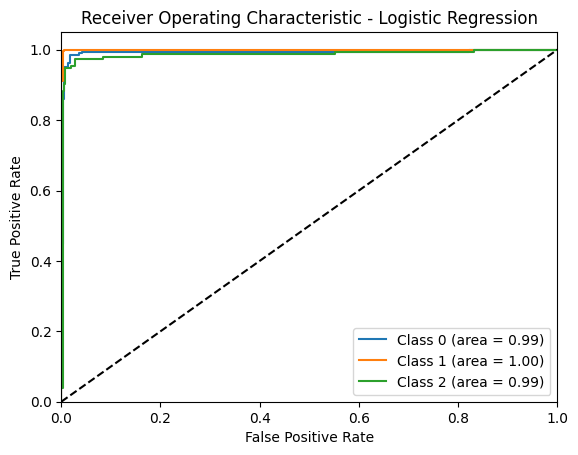

In [37]:
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
y_pred_logistic_proba = logistic_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_logistic_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curve for each class
plt.figure()
for i in range(y_test_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

#### Calculating F1 Score

In [40]:
f1 = f1_score(y_test, y_pred_logistic, average='weighted')
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9705


## Model Evaluation
<a id="Model-Evaluation"></a>

### Plotting the Confusion Matrix
<a id="CM"></a>

Confusion matrices are used to evaluate the performance of classification models by showing the counts of true positive, true negative, false positive, and false negative predictions. The confusion matrix helps in understanding how well the model distinguishes between the different classes.

The confusion matrices for the CNN, LSTM, and SVM models are plotted to compare their classification performance visually. Each matrix displays the counts of predictions for each class, allowing for a detailed assessment of model performance.

In [41]:
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['NEGATIVE', 'POSITIVE', 'NEUTRAL'], 
                yticklabels=['NEGATIVE', 'POSITIVE', 'NEUTRAL'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

In [42]:
# Convert probabilities to class labels
y_pred_cnn_classes = y_pred_cnn.argmax(axis=1)
y_pred_lstm_classes = y_pred_lstm.argmax(axis=1)

# Convert decision function scores to class labels
y_pred_svm_classes = svm_model.predict(X_test)

In [43]:
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn_classes)
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm_classes)
conf_matrix_lr = confusion_matrix(y_test, y_pred_logistic)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm_classes)

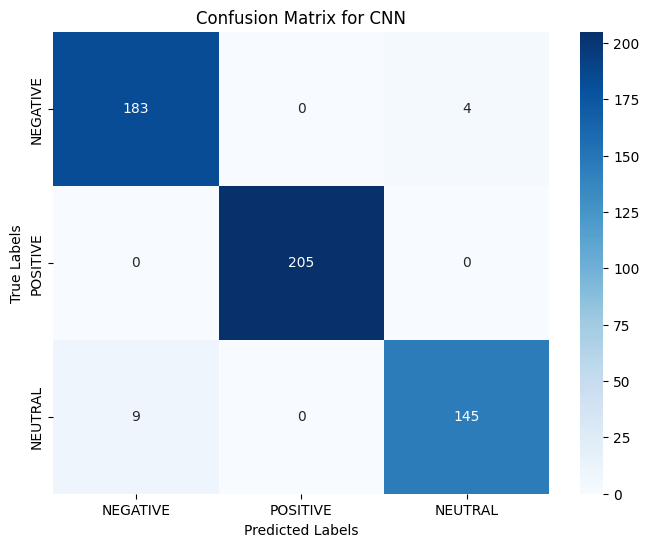

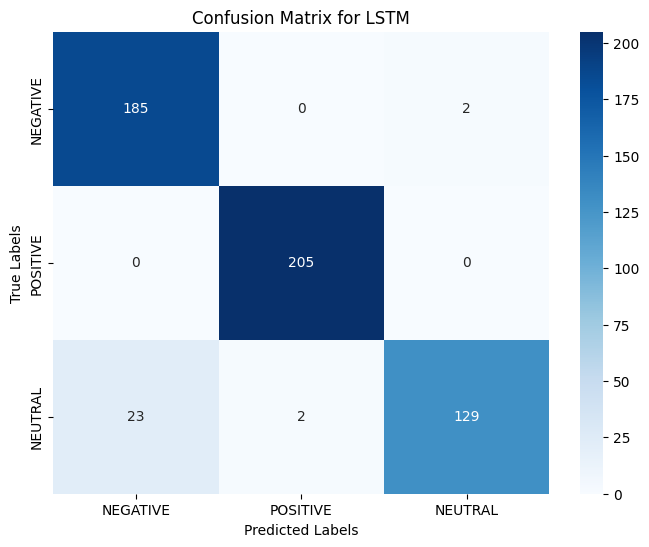

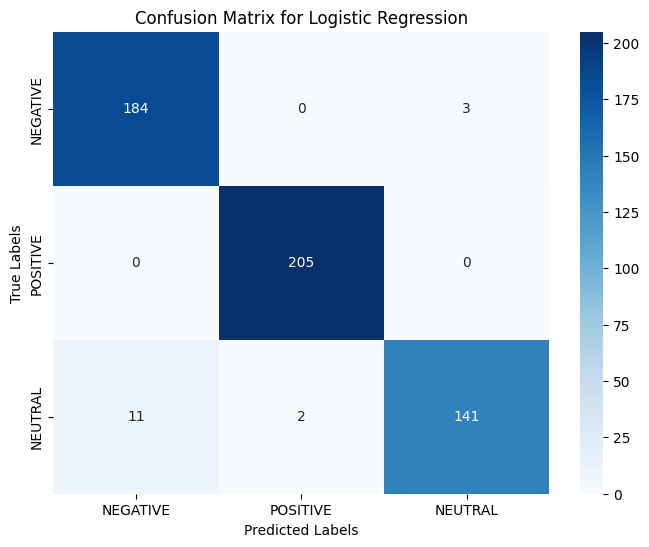

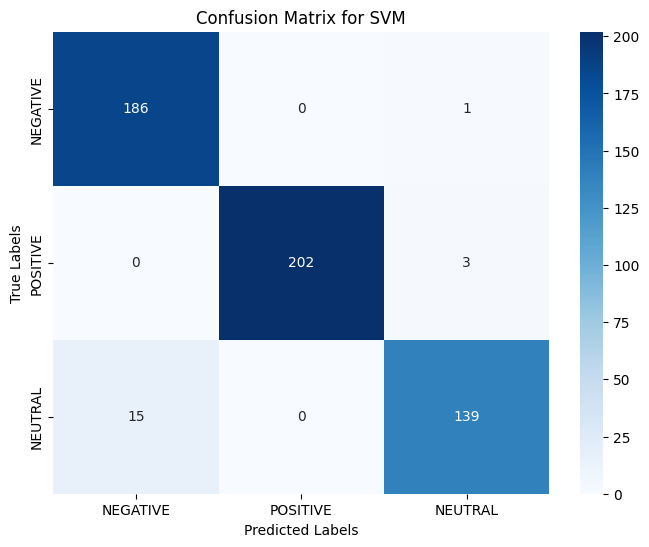

In [44]:
# Plot confusion matrices
plot_confusion_matrix(conf_matrix_cnn, 'Confusion Matrix for CNN')
plot_confusion_matrix(conf_matrix_lstm, 'Confusion Matrix for LSTM')
plot_confusion_matrix(conf_matrix_lr, 'Confusion Matrix for Logistic Regression')
plot_confusion_matrix(conf_matrix_svm, 'Confusion Matrix for SVM')

### Plotting the ROC Curves
<a id="ROC"></a>

The ROC curves for the CNN, LSTM, and SVM models are plotted to visually compare their performance. The ROC curve is a useful tool for evaluating the trade-offs between true positive rate and false positive rate at various threshold levels. 

The plot includes the following:

- **CNN ROC Curve**: Represented in blue, showing the trade-off between true positive rate and false positive rate for the CNN model.
- **LSTM ROC Curve**: Represented in green, illustrating the performance of the LSTM model.
- **SVM ROC Curve**: Represented in red, depicting the performance of the SVM model.
- **Diagonal Line**: A black dashed line representing a random classifier for reference.

The Area Under the Curve (AUC) is displayed in the legend for each model, providing a quantitative measure of performance.

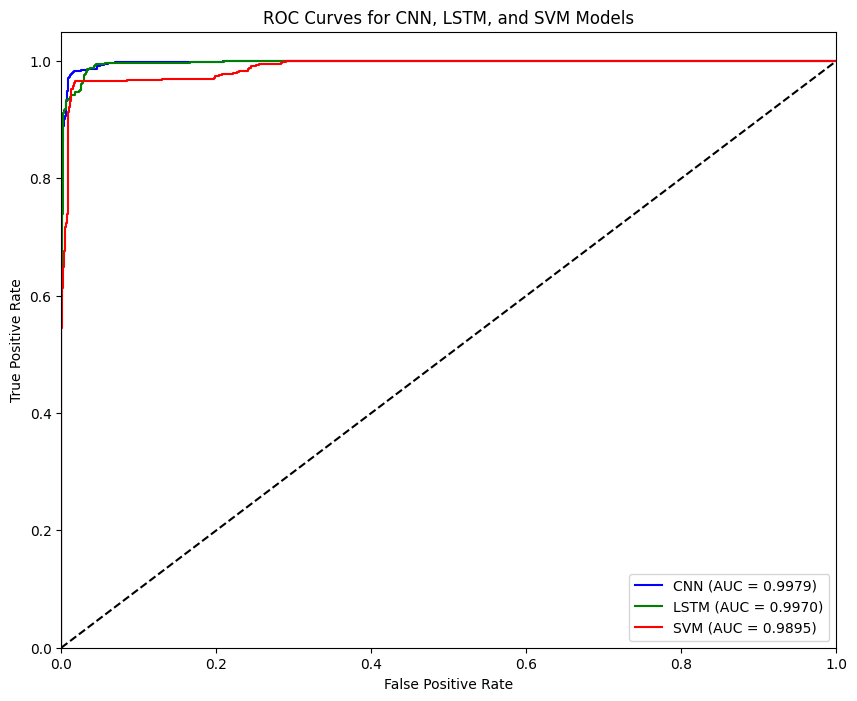

In [45]:
# Plotting the ROC Curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_cnn, tpr_cnn, color='blue', label=f'CNN (AUC = {auc_cnn:.4f})')
plt.plot(fpr_lstm, tpr_lstm, color='green', label=f'LSTM (AUC = {auc_lstm:.4f})')
plt.plot(fpr_svm, tpr_svm, color='red', label=f'SVM (AUC = {auc_svm:.4f})')

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for CNN, LSTM, and SVM Models')
plt.legend(loc="lower right")
plt.show()

### Plotting Saply plots
<a id="Saply"></a>

SHAP (SHapley Additive exPlanations) values are used to interpret machine learning models by quantifying the contribution of each feature to the model's predictions. SHAP values provide insights into how individual features impact the model's output and help in understanding the model's decision-making process.

For each model, SHAP values are calculated using a subset of the test data. These values are then visualized using SHAP plots, which include:

- **Summary Plot**: Displays the distribution of SHAP values for each feature across all samples. It provides insights into feature importance and the effect of each feature on the model's predictions.
- **Dependence Plot**: Shows the relationship between the SHAP value of a feature and its actual value, helping to understand how the feature impacts the model's predictions.

SHAP plots help in interpreting complex models like CNNs and LSTMs, offering a transparent view into the model's behavior and feature importance.

#### Preparing Data for SHAP Calculations

To efficiently compute SHAP values and interpret model predictions, a smaller subset of the test data is selected. This subset allows for quicker computations and analysis. 

The data is reshaped according to the requirements of each model:

- **CNN Model**: The subset is reshaped into four dimensions (`samples, features, 1, 1`) to match the input shape expected by the CNN.
- **LSTM Model**: The subset is reshaped into three dimensions (`samples, timesteps, features`) for the LSTM model.

These reshaped subsets are used for calculating SHAP values to gain insights into the model's predictions.

In [46]:
# Select a small subset of the data for SHAP calculations to save computation time
X_sample = X_test[:100]  # Adjust the number of samples as needed

# Reshape the sample for the model
X_sample_cnn = X_sample.reshape(-1, X_sample.shape[1], 1, 1)
X_sample_lstm = X_sample.reshape(X_sample.shape[0], 1, X_sample.shape[1])

In [47]:
# SHAP for CNN
explainer_cnn = shap.GradientExplainer(cnn_model, X_sample_cnn)
shap_values_cnn = explainer_cnn.shap_values(X_sample_cnn)

Shape of SHAP values: (100, 2548)


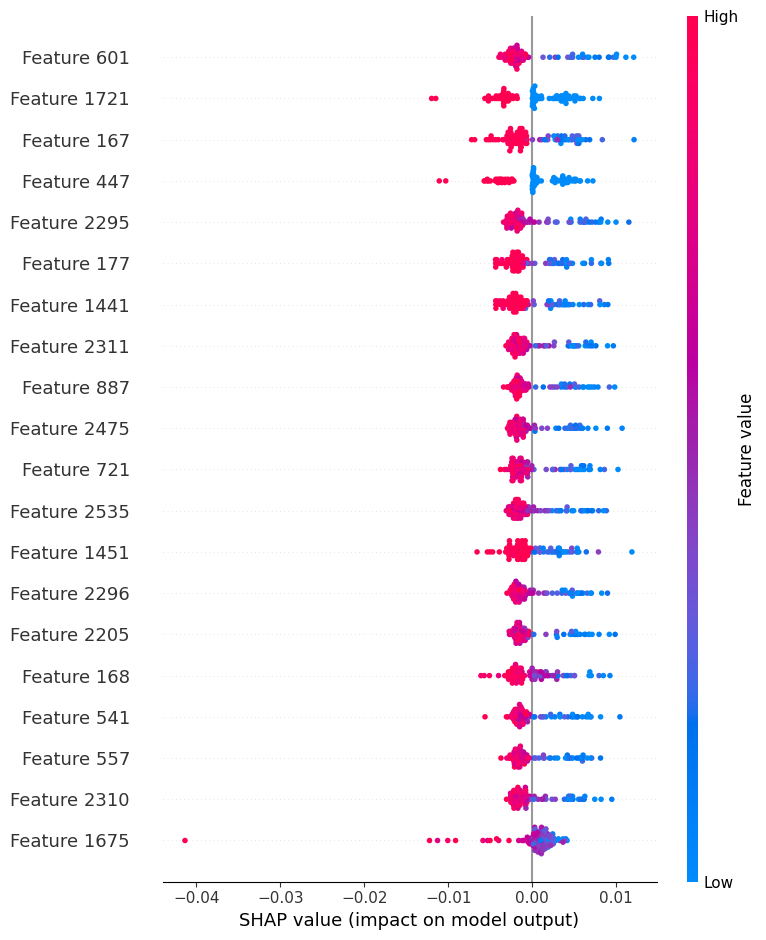

In [48]:
X_sample_cnn_flat = X_sample_lstm.reshape(X_sample_cnn.shape[0], -1)
shap_values_cnn_class0 = shap_values_cnn[:, :, 0, 0, 0]
print(f"Shape of SHAP values: {np.array(shap_values_cnn_class0).shape}")
# Feature names
feature_names_cnn = [f'Feature {i}' for i in range(shap_values_cnn_class0.shape[1])]

# Plot SHAP summary plot for CNN
shap.summary_plot(shap_values_cnn_class0, X_sample_cnn_flat, feature_names=feature_names_cnn)

In [49]:
# SHAP for LSTM
explainer_lstm = shap.GradientExplainer(lstm_model, X_sample_lstm)
shap_values_lstm = explainer_lstm.shap_values(X_sample_lstm)

Shape of SHAP values: (100, 2548)


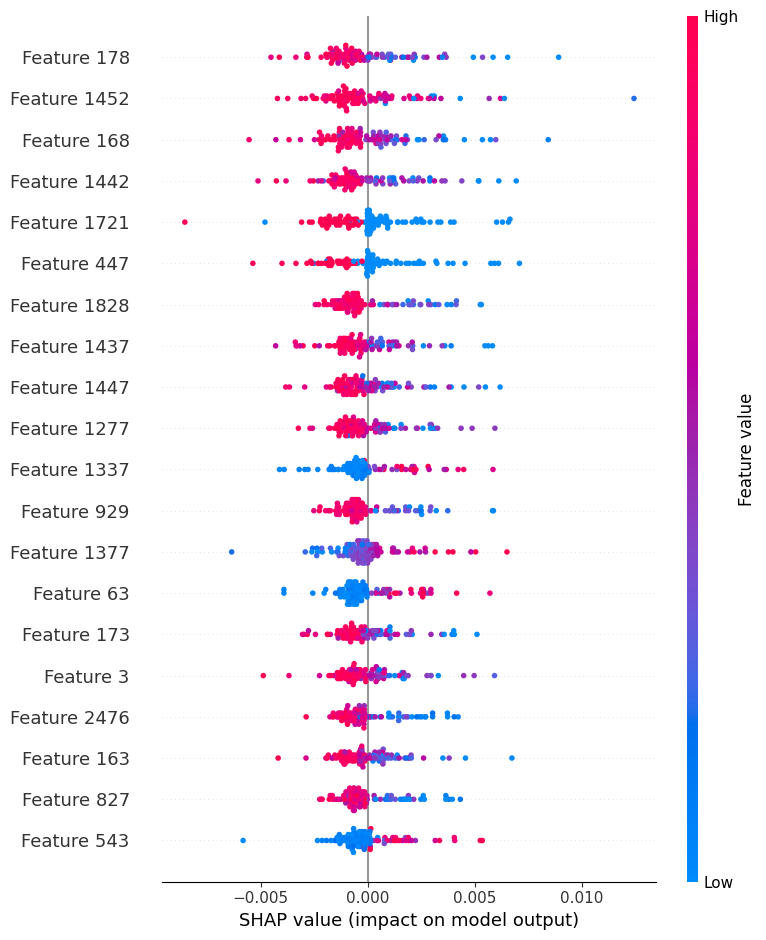

In [50]:
X_sample_lstm_flat = X_sample_lstm.reshape(X_sample_lstm.shape[0], -1)
shap_values_lstm_class0 = shap_values_lstm[:, 0, :, 0]
print(f"Shape of SHAP values: {np.array(shap_values_lstm_class0).shape}")

feature_names_lstm = [f'Feature {i}' for i in range(shap_values_lstm_class0.shape[1])]

# Plot SHAP summary plot for CNN
shap.summary_plot(shap_values_lstm_class0, X_sample_lstm_flat, feature_names=feature_names_lstm)